## Imports

In [1]:
%matplotlib inline

import math, time, random, datetime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import missingno
import seaborn as sns
plt.style.use('seaborn-whitegrid')

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize

import catboost
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool, cv

import warnings
warnings.filterwarnings('ignore')

## Loading the data

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
gender_submission = pd.read_csv('data/gender_submission.csv')

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
len(train)

891

In [5]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [6]:
gender_submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


## Data Descriptions

In [7]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## What missing values are there? 

In [8]:
train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


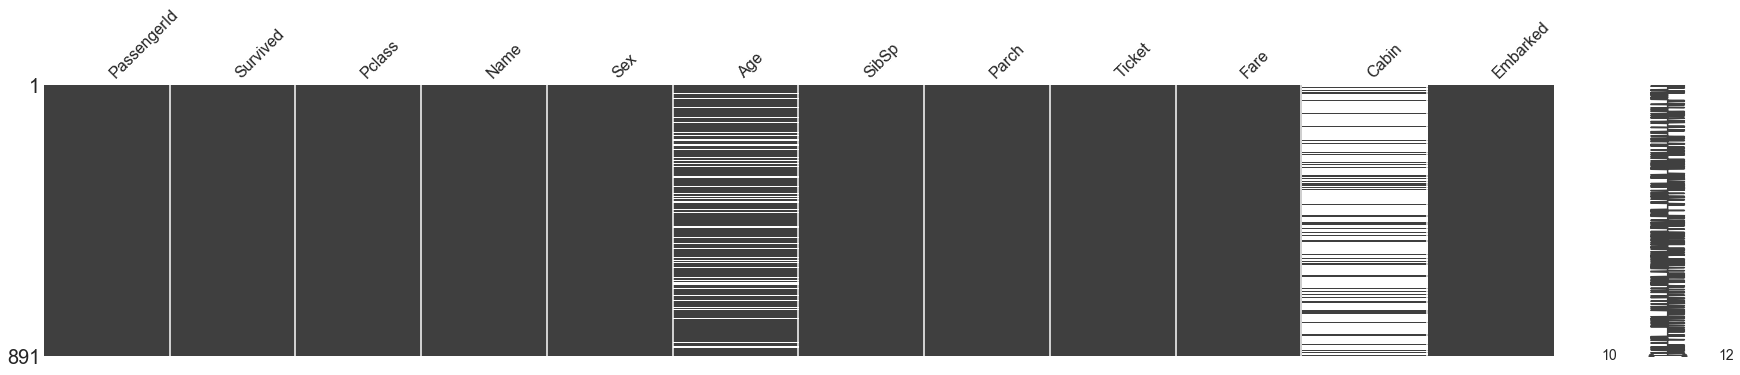

In [9]:
missingno.matrix(train, figsize=(30,5))

In [10]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [11]:
def find_missing_values(df, columns):
    missing_vals = {}
    print('Number of missing or NaN vlues for each column:')
    df_length = len(df)
    for column in columns:
        total_column_values = df[column].value_counts().sum()
        missing_vals[column] = df_length - total_column_values
    return missing_vals

missing_values = find_missing_values(train, columns=train.columns)
missing_values

Number of missing or NaN vlues for each column:


{'Age': 177,
 'Cabin': 687,
 'Embarked': 2,
 'Fare': 0,
 'Name': 0,
 'Parch': 0,
 'PassengerId': 0,
 'Pclass': 0,
 'Sex': 0,
 'SibSp': 0,
 'Survived': 0,
 'Ticket': 0}

## Creating two dataframes 

In [12]:
df_bin = pd.DataFrame() #for dicretised continous variables
df_con = pd.DataFrame() #for continous variables

## What datatypes in the dataframe?

In [13]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

## Exploring each individually

In [14]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Feature : Survived
0 : not survive <br>
1 : survived

0    549
1    342
Name: Survived, dtype: int64


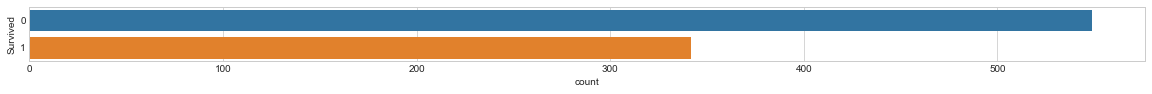

In [15]:
fig = plt.figure(figsize=(20,1))
sns.countplot(y='Survived', data=train)
print(train.Survived.value_counts())

In [16]:
df_bin['Survived'] = train['Survived']
df_con['Survived'] = train['Survived']
df_bin.head(2)

,Survived
0,0
1,1


## Feature : Class
1 : 1st <br>
2 : 2nd <br>
3 : 3rd

In [17]:
train.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S


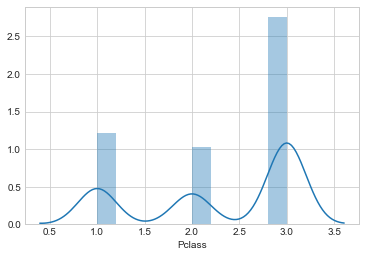

In [18]:
sns.distplot(train.Pclass)

These features are numerical but they are categorical

In [19]:
missing_values['Pclass']

0

In [20]:
df_bin['Pclass'] = train['Pclass']
df_con['Pclass'] = train['Pclass']

In [21]:
df_bin.head(2)

,Survived,Pclass
0,0,3
1,1,1


## Feature : Name

In [22]:
train.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S


In [23]:
train.Name.value_counts()

Sinkkonen, Miss. Anna                                   1
Lefebre, Master. Henry Forbes                           1
Murdlin, Mr. Joseph                                     1
Roebling, Mr. Washington Augustus II                    1
Jonsson, Mr. Carl                                       1
Moran, Mr. Daniel J                                     1
Mudd, Mr. Thomas Charles                                1
Renouf, Mr. Peter Henry                                 1
Sobey, Mr. Samuel James Hayden                          1
Bailey, Mr. Percy Andrew                                1
Boulos, Mrs. Joseph (Sultana)                           1
Dick, Mr. Albert Adrian                                 1
Lefebre, Miss. Ida                                      1
Allison, Miss. Helen Loraine                            1
Bourke, Mr. John                                        1
Theobald, Mr. Thomas Leonard                            1
Gill, Mr. John William                                  1
Panula, Master

## Feature : Sex
male <br>
female

In [24]:
train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


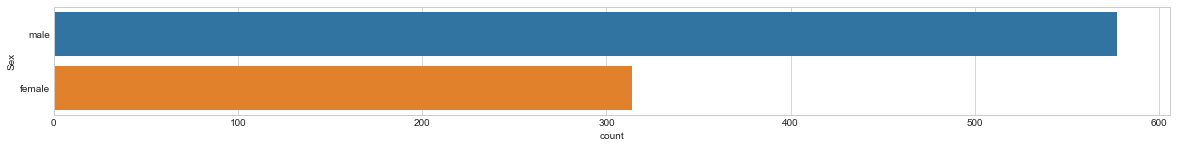

In [25]:
plt.figure(figsize=(20, 2))
sns.countplot(y='Sex', data=train)

In [26]:
missing_values['Sex']

0

In [27]:
df_bin['Sex'] = train['Sex']
df_bin['Sex'] = np.where(df_bin['Sex'] == 'female', 1, 0)
df_con['Sex'] = train['Sex']

In [28]:
df_bin.head()

,Survived,Pclass,Sex
0,0,3,0
1,1,1,1
2,1,3,1
3,1,1,1
4,0,3,0


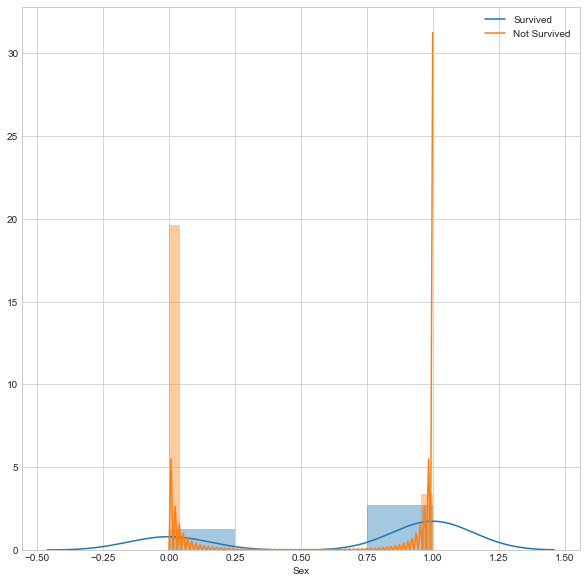

In [29]:
# How does the sex variable compared to Survival?
fig = plt.figure(figsize=(10, 10))
sns.distplot(df_bin.loc[df_bin['Survived'] == 1]['Sex'], kde_kws={'label':'Survived'}) 
sns.distplot(df_bin.loc[df_bin['Survived'] == 0]['Sex'], kde_kws={'label':'Not Survived'})

## Feature : Age

In [30]:
missing_values['Age']

177

Options to fill : 
1. Fill them with average
2. Reject the whole rows where age is not specified

In [31]:
train.Age.head(10)

0    22.0
1    38.0
2    26.0
3    35.0
4    35.0
5     NaN
6    54.0
7     2.0
8    27.0
9    14.0
Name: Age, dtype: float64

In [32]:
# filling them with average
train['Age'] = train['Age'].replace(0, np.NaN)
train['Age'].fillna(train['Age'].mean(), inplace=True)

In [33]:
train.Age.head(10)

0    22.000000
1    38.000000
2    26.000000
3    35.000000
4    35.000000
5    29.699118
6    54.000000
7     2.000000
8    27.000000
9    14.000000
Name: Age, dtype: float64

In [34]:
# dropping rows with missing values 
# train['Age'].dropna(inplace=True)
len(train)

891

In [35]:
df_bin['Age'] = pd.cut(train['Age'], 10) # bucketed/binned into different categories
df_con['Age'] = train['Age'] # non-bucketed

In [36]:
df_bin.head()

,Survived,Pclass,Sex,Age
0,0,3,0,"(16.336, 24.294]"
1,1,1,1,"(32.252, 40.21]"
2,1,3,1,"(24.294, 32.252]"
3,1,1,1,"(32.252, 40.21]"
4,0,3,0,"(32.252, 40.21]"


In [37]:
df_con.head()

,Survived,Pclass,Sex,Age
0,0,3,male,22.0
1,1,1,female,38.0
2,1,3,female,26.0
3,1,1,female,35.0
4,0,3,male,35.0


In [38]:
def plot_count_dist(data, bin_df, label_column, target_column, figsize=(20, 5), use_bin_df=False):
    """
    Function to plot counts and distributions of a label variable and 
    target variable side by side.
    ::param_data:: = target dataframe
    ::param_bin_df:: = binned dataframe for countplot
    ::param_label_column:: = binary labelled column
    ::param_target_column:: = column you want to view counts and distributions
    ::param_figsize:: = size of figure (width, height)
    ::param_use_bin_df:: = whether or not to use the bin_df, default False
    """
    if use_bin_df: 
        fig = plt.figure(figsize=figsize)
        plt.subplot(1, 2, 1)
        sns.countplot(y=target_column, data=bin_df);
        plt.subplot(1, 2, 2)
        sns.distplot(data.loc[data[label_column] == 1][target_column], 
                     kde_kws={"label": "Survived"});
        sns.distplot(data.loc[data[label_column] == 0][target_column], 
                     kde_kws={"label": "Did not survive"});
    else:
        fig = plt.figure(figsize=figsize)
        plt.subplot(1, 2, 1)
        sns.countplot(y=target_column, data=data);
        plt.subplot(1, 2, 2)
        sns.distplot(data.loc[data[label_column] == 1][target_column], 
                     kde_kws={"label": "Survived"});
        sns.distplot(data.loc[data[label_column] == 0][target_column], 
                     kde_kws={"label": "Did not survive"});

## Feature: SibSp
Number of siblings / spouses the passenger has onboard

In [39]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [40]:
missing_values['SibSp']

0

In [41]:
train.SibSp.value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [42]:
df_bin['SibSp'] = train['SibSp']
df_con['SibSp'] = train['SibSp']

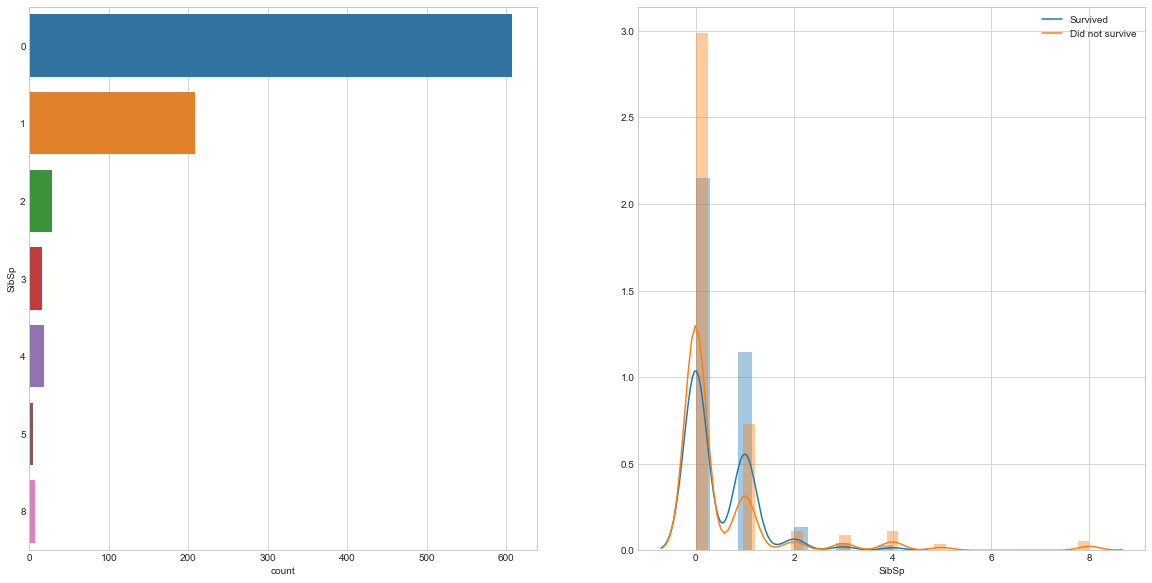

In [43]:
plot_count_dist(train, 
                bin_df=df_bin, 
                label_column='Survived', 
                target_column='SibSp', 
                figsize=(20, 10))

## Feature: Parch
The number of parents/children the passenger has onboard

In [44]:
missing_values['Parch']

0

In [45]:
train.Parch.value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

In [46]:
df_bin['Parch'] = train['Parch']
df_con['Parch'] = train['Parch']

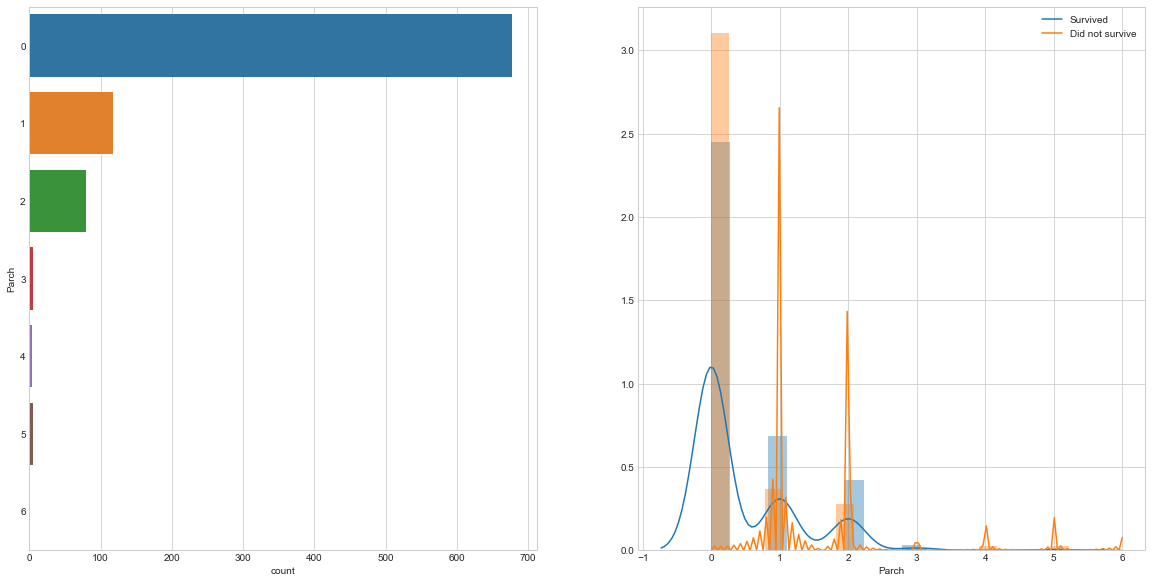

In [47]:
plot_count_dist(train, 
                bin_df=df_bin,
                label_column='Survived', 
                target_column='Parch', 
                figsize=(20, 10))

## Feature: Ticket
ticket number

In [48]:
missing_values['Ticket']

0

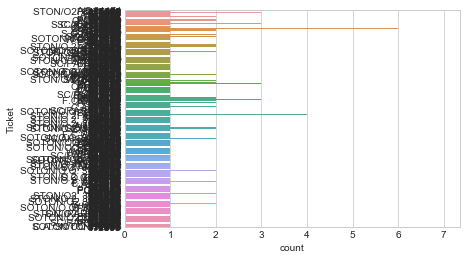

In [49]:
sns.countplot(y='Ticket', data=train)

In [50]:
train.Ticket.value_counts()

347082                7
1601                  7
CA. 2343              7
347088                6
CA 2144               6
3101295               6
382652                5
S.O.C. 14879          5
17421                 4
4133                  4
347077                4
349909                4
PC 17757              4
2666                  4
19950                 4
LINE                  4
113781                4
W./C. 6608            4
113760                4
239853                3
F.C.C. 13529          3
C.A. 31921            3
29106                 3
110152                3
363291                3
371110                3
SC/Paris 2123         3
35273                 3
248727                3
347742                3
                     ..
STON/O2. 3101283      1
3101281               1
250646                1
350052                1
19972                 1
349210                1
SW/PP 751             1
W.E.P. 5734           1
SCO/W 1585            1
336439                1
SC/PARIS 2149   

In [51]:
print('There are {} unique Ticket Values.'.format(len(train.Ticket.unique())))

There are 681 unique Ticket Values.


### Challenge : 
how to reduce the ticket feature from 681 to less

## Feature: Fare
How much the ticket cost

In [52]:
missing_values['Fare']

0

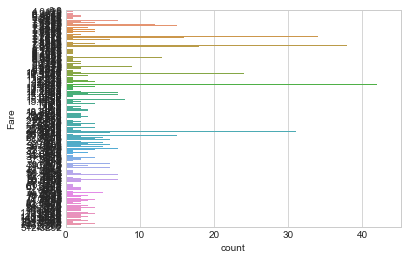

In [53]:
sns.countplot(y='Fare', data=train)

In [54]:
train.Fare.dtype

dtype('float64')

In [55]:
print('There are {} unique fare values.'.format(len(train.Fare.unique())))

There are 248 unique fare values.


In [56]:
df_con['Fare'] = train['Fare']
df_bin['Fare'] = pd.cut(train['Fare'], 5)

In [57]:
df_bin.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,0,"(16.336, 24.294]",1,0,"(-0.512, 102.466]"
1,1,1,1,"(32.252, 40.21]",1,0,"(-0.512, 102.466]"
2,1,3,1,"(24.294, 32.252]",0,0,"(-0.512, 102.466]"
3,1,1,1,"(32.252, 40.21]",1,0,"(-0.512, 102.466]"
4,0,3,0,"(32.252, 40.21]",0,0,"(-0.512, 102.466]"


In [58]:
df_con.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,male,22.0,1,0,7.2500
1,1,1,female,38.0,1,0,71.2833
2,1,3,female,26.0,0,0,7.9250
3,1,1,female,35.0,1,0,53.1000
4,0,3,male,35.0,0,0,8.0500


In [59]:
df_bin.Fare.value_counts()

(-0.512, 102.466]     838
(102.466, 204.932]     33
(204.932, 307.398]     17
(409.863, 512.329]      3
(307.398, 409.863]      0
Name: Fare, dtype: int64

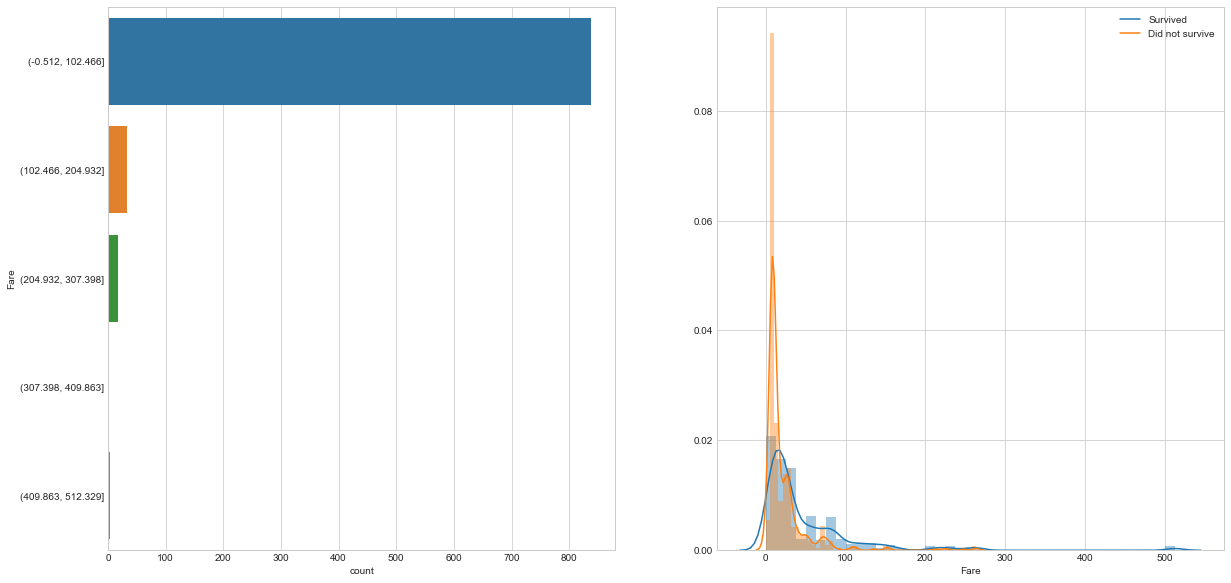

In [60]:
plot_count_dist(data=train,
                bin_df=df_bin,
                label_column='Survived', 
                target_column='Fare', 
                figsize=(20,10), 
                use_bin_df=True)

**Challenge:** How to change the Fare bins?  

## Feature: Cabin
the cabin number where the passenger was staying

In [61]:
missing_values['Cabin']

687

In [62]:
train.Cabin.value_counts()

C23 C25 C27    4
B96 B98        4
G6             4
C22 C26        3
E101           3
D              3
F33            3
F2             3
E67            2
B18            2
C65            2
D36            2
C52            2
B20            2
C92            2
E121           2
C2             2
C78            2
E25            2
B22            2
B49            2
B28            2
D20            2
B77            2
F G73          2
E44            2
B5             2
C126           2
C125           2
B35            2
              ..
A10            1
D10 D12        1
A6             1
A26            1
B101           1
A19            1
B38            1
A23            1
A20            1
B79            1
C62 C64        1
A31            1
F G63          1
B78            1
B30            1
B19            1
E31            1
B86            1
B94            1
B102           1
C103           1
C32            1
D48            1
C45            1
D37            1
C91            1
B41            1
B69           

How to make it more usable?

## Feature: Embarked
the port where the passenger boarded the Titanic <br>
C : Cherbourg <br>
Q : Queenstown <br>
S : Southampton

In [63]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [64]:
missing_values['Embarked']

2

In [65]:
train.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

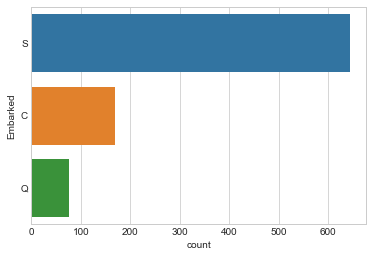

In [66]:
sns.countplot(y='Embarked', data=train)

**How to deal with 2 missing values of Embarked?** <br>
Options :
1. drop the two rows
2. randomly assign C, Q or S

In [67]:
df_bin['Embarked'] = train['Embarked']
df_con['Embarked'] = train['Embarked']

In [68]:
print(len(df_con))
df_con = df_con.dropna(subset=['Embarked'])
df_bin = df_bin.dropna(subset=['Embarked'])
print(len(df_con))

891
889


In [69]:
df_bin.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,"(16.336, 24.294]",1,0,"(-0.512, 102.466]",S
1,1,1,1,"(32.252, 40.21]",1,0,"(-0.512, 102.466]",C
2,1,3,1,"(24.294, 32.252]",0,0,"(-0.512, 102.466]",S
3,1,1,1,"(32.252, 40.21]",1,0,"(-0.512, 102.466]",S
4,0,3,0,"(32.252, 40.21]",0,0,"(-0.512, 102.466]",S


In [70]:
df_con.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


## Feature Encoding
Now we have our two sub dataframes ready. We can encode the features so they're ready to be used with our machine learning models.

We will encode our binned dataframe (df_bin) with one-hot encoding and our continuous dataframe (df_con) with the label encoding function from sklearn.

In [71]:
df_bin.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,"(16.336, 24.294]",1,0,"(-0.512, 102.466]",S
1,1,1,1,"(32.252, 40.21]",1,0,"(-0.512, 102.466]",C
2,1,3,1,"(24.294, 32.252]",0,0,"(-0.512, 102.466]",S
3,1,1,1,"(32.252, 40.21]",1,0,"(-0.512, 102.466]",S
4,0,3,0,"(32.252, 40.21]",0,0,"(-0.512, 102.466]",S


In [72]:
# One-hot encode binned variables
one_hot_cols = df_bin.columns.tolist()
one_hot_cols.remove('Survived')
df_bin_enc = pd.get_dummies(df_bin, columns=one_hot_cols)

df_bin_enc.head()

,Survived,Pclass_1,Pclass_2,Pclass_3,Sex_0,Sex_1,"Age_(0.34, 8.378]","Age_(8.378, 16.336]","Age_(16.336, 24.294]","Age_(24.294, 32.252]",...,Parch_5,Parch_6,"Fare_(-0.512, 102.466]","Fare_(102.466, 204.932]","Fare_(204.932, 307.398]","Fare_(307.398, 409.863]","Fare_(409.863, 512.329]",Embarked_C,Embarked_Q,Embarked_S
0,0,0,0,1,1,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1
1,1,1,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
2,1,0,0,1,0,1,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
3,1,1,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
4,0,0,0,1,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [73]:
df_con.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [74]:
# Label Encode all continous values LabelEncoder()
df_con_enc = df_con.apply(LabelEncoder().fit_transform)

df_con_enc.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,2,1,28,1,0,18,2
1,1,0,0,52,1,0,207,0
2,1,2,0,34,0,0,41,2
3,1,0,0,48,1,0,189,2
4,0,2,1,48,0,0,43,2


## Start Building Machine Learning Models

In [75]:
# Select the dataFrame we want to use first for predictions
selected_df = df_con_enc

In [77]:
# Split the data into data and labels
X_train = selected_df.drop('Survived', axis=1)
y_train = selected_df.Survived

In [78]:
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,2,1,28,1,0,18,2
1,0,0,52,1,0,207,0
2,2,0,34,0,0,41,2
3,0,0,48,1,0,189,2
4,2,1,48,0,0,43,2


In [79]:
y_train.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

### Define a function to fit machine learning algorithms

In [80]:
def fit_ml_algo(algo, X_train, y_train, cv):
    
    # one pass
    model = algo.fit(X_train, y_train)
    acc = round(model.score(X_train, y_train) * 100, 2)
    
    # cross validation
    train_pred = model_selection.cross_val_predict(algo,
                                                  X_train,
                                                  y_train,
                                                  cv=cv,
                                                  n_jobs= -1)
    acc_cv = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)
    
    return train_pred, acc, acc_cv

### Logistic Regression

In [81]:
# Logistic Regression
start_time = time.time()
train_pred_log, acc_log, acc_cv_log = fit_ml_algo(LogisticRegression(),
                                                 X_train,
                                                 y_train,
                                                 10)
log_time = (time.time() - start_time)
print("Accuracy: %s" % acc_log)
print("Accuracy CV 10-Fold: %s" % acc_cv_log)
print("Running Time: %s" % datetime.timedelta(seconds=log_time))

Accuracy: 79.42
Accuracy CV 10-Fold: 79.08
Running Time: 0:00:13.526397


### K-Nearest Neighbours

In [82]:
# k-Nearest Neighbours
start_time = time.time()
train_pred_knn, acc_knn, acc_cv_knn = fit_ml_algo(KNeighborsClassifier(), 
                                                  X_train, 
                                                  y_train, 
                                                  10)
knn_time = (time.time() - start_time)
print("Accuracy: %s" % acc_knn)
print("Accuracy CV 10-Fold: %s" % acc_cv_knn)
print("Running Time: %s" % datetime.timedelta(seconds=knn_time))

Accuracy: 78.63
Accuracy CV 10-Fold: 69.63
Running Time: 0:00:13.300526


### Gaussian Naive Bayes

In [83]:
# Gaussian Naive Bayes
start_time = time.time()
train_pred_gaussian, acc_gaussian, acc_cv_gaussian = fit_ml_algo(GaussianNB(), 
                                                                      X_train, 
                                                                      y_train, 
                                                                           10)
gaussian_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gaussian)
print("Accuracy CV 10-Fold: %s" % acc_cv_gaussian)
print("Running Time: %s" % datetime.timedelta(seconds=gaussian_time))

Accuracy: 76.38
Accuracy CV 10-Fold: 76.27
Running Time: 0:00:12.853654


### Linear Support Vector Machines (SVC)

In [84]:
# Linear SVC
start_time = time.time()
train_pred_svc, acc_linear_svc, acc_cv_linear_svc = fit_ml_algo(LinearSVC(),
                                                                X_train, 
                                                                y_train, 
                                                                10)
linear_svc_time = (time.time() - start_time)
print("Accuracy: %s" % acc_linear_svc)
print("Accuracy CV 10-Fold: %s" % acc_cv_linear_svc)
print("Running Time: %s" % datetime.timedelta(seconds=linear_svc_time))

Accuracy: 76.38
Accuracy CV 10-Fold: 72.22
Running Time: 0:00:12.873045


### Stochastic Gradient Descent

In [85]:
# Stochastic Gradient Descent
start_time = time.time()
train_pred_sgd, acc_sgd, acc_cv_sgd = fit_ml_algo(SGDClassifier(), 
                                                  X_train, 
                                                  y_train,
                                                  10)
sgd_time = (time.time() - start_time)
print("Accuracy: %s" % acc_sgd)
print("Accuracy CV 10-Fold: %s" % acc_cv_sgd)
print("Running Time: %s" % datetime.timedelta(seconds=sgd_time))

Accuracy: 42.63
Accuracy CV 10-Fold: 54.44
Running Time: 0:00:13.629801


### Decision Tree Classifier

In [86]:
# Decision Tree Classifier
start_time = time.time()
train_pred_dt, acc_dt, acc_cv_dt = fit_ml_algo(DecisionTreeClassifier(), 
                                                                X_train, 
                                                                y_train,
                                                                10)
dt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_dt)
print("Accuracy CV 10-Fold: %s" % acc_cv_dt)
print("Running Time: %s" % datetime.timedelta(seconds=dt_time))

Accuracy: 98.2
Accuracy CV 10-Fold: 77.84
Running Time: 0:00:15.290524


### Gradient Boost Trees

In [87]:
# Gradient Boosting Trees
start_time = time.time()
train_pred_gbt, acc_gbt, acc_cv_gbt = fit_ml_algo(GradientBoostingClassifier(), 
                                                                       X_train, 
                                                                       y_train,
                                                                       10)
gbt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gbt)
print("Accuracy CV 10-Fold: %s" % acc_cv_gbt)
print("Running Time: %s" % datetime.timedelta(seconds=gbt_time))

Accuracy: 89.09
Accuracy CV 10-Fold: 83.01
Running Time: 0:00:13.801808


### CatBoost Algorithm
CatBoost is a state-of-the-art open-source gradient boosting on decision trees library.

It's simple and easy to use. And is now regularly one of my go-to algorithms for any kind of machine learning task.

For more on CatBoost and the methods it uses to deal with categorical variables, check out the https://catboost.ai/.

In [88]:
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,2,1,28,1,0,18,2
1,0,0,52,1,0,207,0
2,2,0,34,0,0,41,2
3,0,0,48,1,0,189,2
4,2,1,48,0,0,43,2


In [89]:
y_train.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [90]:
cat_features = np.where(X_train.dtypes != np.float)[0]
cat_features

array([0, 1, 2, 3, 4, 5, 6], dtype=int64)

In [91]:
train_pool = Pool(X_train,
                  y_train,
                  cat_features)

In [92]:
catboost_model = CatBoostClassifier(iterations= 1000,
                                   custom_loss= ['Accuracy'],
                                   loss_function= 'Logloss')

catboost_model.fit(train_pool,
                  plot=True)

acc_catboost = round(catboost_model.score(X_train, y_train) * 100, 2)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6841272	total: 279ms	remaining: 4m 38s
1:	learn: 0.6747567	total: 338ms	remaining: 2m 48s
2:	learn: 0.6655276	total: 401ms	remaining: 2m 13s
3:	learn: 0.6580280	total: 429ms	remaining: 1m 46s
4:	learn: 0.6503528	total: 450ms	remaining: 1m 29s
5:	learn: 0.6434205	total: 469ms	remaining: 1m 17s
6:	learn: 0.6365369	total: 487ms	remaining: 1m 9s
7:	learn: 0.6298695	total: 512ms	remaining: 1m 3s
8:	learn: 0.6254099	total: 529ms	remaining: 58.2s
9:	learn: 0.6193372	total: 561ms	remaining: 55.6s
10:	learn: 0.6124633	total: 590ms	remaining: 53.1s
11:	learn: 0.6065469	total: 609ms	remaining: 50.2s
12:	learn: 0.6002758	total: 638ms	remaining: 48.4s
13:	learn: 0.5941682	total: 669ms	remaining: 47.1s
14:	learn: 0.5906505	total: 688ms	remaining: 45.2s
15:	learn: 0.5872556	total: 701ms	remaining: 43.1s
16:	learn: 0.5818956	total: 743ms	remaining: 43s
17:	learn: 0.5769945	total: 774ms	remaining: 42.2s
18:	learn: 0.5725906	total: 795ms	remaining: 41.1s
19:	learn: 0.5678945	total: 825ms	rem

161:	learn: 0.4226778	total: 5.13s	remaining: 26.6s
162:	learn: 0.4220295	total: 5.18s	remaining: 26.6s
163:	learn: 0.4219149	total: 5.2s	remaining: 26.5s
164:	learn: 0.4218361	total: 5.23s	remaining: 26.5s
165:	learn: 0.4217431	total: 5.28s	remaining: 26.5s
166:	learn: 0.4216529	total: 5.31s	remaining: 26.5s
167:	learn: 0.4216367	total: 5.33s	remaining: 26.4s
168:	learn: 0.4215369	total: 5.37s	remaining: 26.4s
169:	learn: 0.4214579	total: 5.39s	remaining: 26.3s
170:	learn: 0.4212180	total: 5.41s	remaining: 26.2s
171:	learn: 0.4209840	total: 5.43s	remaining: 26.1s
172:	learn: 0.4204444	total: 5.47s	remaining: 26.1s
173:	learn: 0.4201259	total: 5.5s	remaining: 26.1s
174:	learn: 0.4200246	total: 5.53s	remaining: 26.1s
175:	learn: 0.4195921	total: 5.57s	remaining: 26.1s
176:	learn: 0.4194426	total: 5.59s	remaining: 26s
177:	learn: 0.4189077	total: 5.63s	remaining: 26s
178:	learn: 0.4185837	total: 5.67s	remaining: 26s
179:	learn: 0.4185107	total: 5.7s	remaining: 26s
180:	learn: 0.4184221	t

321:	learn: 0.3960695	total: 10.1s	remaining: 21.3s
322:	learn: 0.3958080	total: 10.2s	remaining: 21.3s
323:	learn: 0.3956898	total: 10.2s	remaining: 21.3s
324:	learn: 0.3956016	total: 10.2s	remaining: 21.3s
325:	learn: 0.3955744	total: 10.3s	remaining: 21.2s
326:	learn: 0.3954776	total: 10.3s	remaining: 21.2s
327:	learn: 0.3954765	total: 10.3s	remaining: 21.2s
328:	learn: 0.3952248	total: 10.4s	remaining: 21.1s
329:	learn: 0.3951376	total: 10.4s	remaining: 21.1s
330:	learn: 0.3950074	total: 10.4s	remaining: 21.1s
331:	learn: 0.3947545	total: 10.5s	remaining: 21.1s
332:	learn: 0.3946949	total: 10.5s	remaining: 21s
333:	learn: 0.3946723	total: 10.5s	remaining: 21s
334:	learn: 0.3943712	total: 10.6s	remaining: 20.9s
335:	learn: 0.3940772	total: 10.6s	remaining: 20.9s
336:	learn: 0.3940542	total: 10.6s	remaining: 20.9s
337:	learn: 0.3940034	total: 10.6s	remaining: 20.8s
338:	learn: 0.3940033	total: 10.7s	remaining: 20.8s
339:	learn: 0.3939842	total: 10.7s	remaining: 20.7s
340:	learn: 0.39

482:	learn: 0.3775509	total: 15s	remaining: 16.1s
483:	learn: 0.3775145	total: 15.1s	remaining: 16s
484:	learn: 0.3774885	total: 15.1s	remaining: 16s
485:	learn: 0.3774848	total: 15.1s	remaining: 16s
486:	learn: 0.3773029	total: 15.2s	remaining: 16s
487:	learn: 0.3772207	total: 15.2s	remaining: 15.9s
488:	learn: 0.3770795	total: 15.2s	remaining: 15.9s
489:	learn: 0.3770794	total: 15.2s	remaining: 15.9s
490:	learn: 0.3768910	total: 15.3s	remaining: 15.8s
491:	learn: 0.3767968	total: 15.3s	remaining: 15.8s
492:	learn: 0.3767525	total: 15.3s	remaining: 15.8s
493:	learn: 0.3767525	total: 15.4s	remaining: 15.7s
494:	learn: 0.3766609	total: 15.4s	remaining: 15.7s
495:	learn: 0.3765551	total: 15.4s	remaining: 15.7s
496:	learn: 0.3764555	total: 15.5s	remaining: 15.7s
497:	learn: 0.3762966	total: 15.5s	remaining: 15.6s
498:	learn: 0.3760612	total: 15.5s	remaining: 15.6s
499:	learn: 0.3759522	total: 15.6s	remaining: 15.6s
500:	learn: 0.3757987	total: 15.6s	remaining: 15.6s
501:	learn: 0.3756955	

643:	learn: 0.3502227	total: 21.5s	remaining: 11.9s
644:	learn: 0.3501393	total: 21.6s	remaining: 11.9s
645:	learn: 0.3496027	total: 21.6s	remaining: 11.8s
646:	learn: 0.3493473	total: 21.7s	remaining: 11.8s
647:	learn: 0.3491074	total: 21.7s	remaining: 11.8s
648:	learn: 0.3490414	total: 21.7s	remaining: 11.8s
649:	learn: 0.3489707	total: 21.8s	remaining: 11.7s
650:	learn: 0.3487725	total: 21.8s	remaining: 11.7s
651:	learn: 0.3486201	total: 21.9s	remaining: 11.7s
652:	learn: 0.3485690	total: 21.9s	remaining: 11.6s
653:	learn: 0.3483278	total: 21.9s	remaining: 11.6s
654:	learn: 0.3482686	total: 22s	remaining: 11.6s
655:	learn: 0.3481685	total: 22s	remaining: 11.6s
656:	learn: 0.3480478	total: 22.1s	remaining: 11.5s
657:	learn: 0.3478780	total: 22.1s	remaining: 11.5s
658:	learn: 0.3476451	total: 22.2s	remaining: 11.5s
659:	learn: 0.3476229	total: 22.2s	remaining: 11.4s
660:	learn: 0.3475055	total: 22.3s	remaining: 11.4s
661:	learn: 0.3472657	total: 22.3s	remaining: 11.4s
662:	learn: 0.34

805:	learn: 0.3266717	total: 28.6s	remaining: 6.87s
806:	learn: 0.3266526	total: 28.6s	remaining: 6.84s
807:	learn: 0.3265252	total: 28.7s	remaining: 6.82s
808:	learn: 0.3261898	total: 28.7s	remaining: 6.78s
809:	learn: 0.3261425	total: 28.8s	remaining: 6.74s
810:	learn: 0.3258884	total: 28.8s	remaining: 6.71s
811:	learn: 0.3252535	total: 28.8s	remaining: 6.68s
812:	learn: 0.3250674	total: 28.9s	remaining: 6.64s
813:	learn: 0.3247956	total: 28.9s	remaining: 6.61s
814:	learn: 0.3246898	total: 29s	remaining: 6.58s
815:	learn: 0.3246685	total: 29s	remaining: 6.54s
816:	learn: 0.3244467	total: 29.1s	remaining: 6.51s
817:	learn: 0.3244309	total: 29.1s	remaining: 6.47s
818:	learn: 0.3243346	total: 29.1s	remaining: 6.44s
819:	learn: 0.3242549	total: 29.2s	remaining: 6.41s
820:	learn: 0.3239773	total: 29.2s	remaining: 6.37s
821:	learn: 0.3237338	total: 29.3s	remaining: 6.34s
822:	learn: 0.3235186	total: 29.3s	remaining: 6.3s
823:	learn: 0.3234842	total: 29.4s	remaining: 6.27s
824:	learn: 0.323

966:	learn: 0.3075021	total: 35.9s	remaining: 1.22s
967:	learn: 0.3073709	total: 35.9s	remaining: 1.19s
968:	learn: 0.3071152	total: 36s	remaining: 1.15s
969:	learn: 0.3069219	total: 36s	remaining: 1.11s
970:	learn: 0.3068166	total: 36.1s	remaining: 1.08s
971:	learn: 0.3067896	total: 36.1s	remaining: 1.04s
972:	learn: 0.3066718	total: 36.2s	remaining: 1s
973:	learn: 0.3065688	total: 36.2s	remaining: 967ms
974:	learn: 0.3063045	total: 36.3s	remaining: 930ms
975:	learn: 0.3061075	total: 36.3s	remaining: 893ms
976:	learn: 0.3060719	total: 36.4s	remaining: 856ms
977:	learn: 0.3060364	total: 36.4s	remaining: 819ms
978:	learn: 0.3060255	total: 36.4s	remaining: 782ms
979:	learn: 0.3058088	total: 36.5s	remaining: 745ms
980:	learn: 0.3057573	total: 36.5s	remaining: 707ms
981:	learn: 0.3056238	total: 36.6s	remaining: 670ms
982:	learn: 0.3053001	total: 36.6s	remaining: 633ms
983:	learn: 0.3052967	total: 36.7s	remaining: 596ms
984:	learn: 0.3050969	total: 36.7s	remaining: 559ms
985:	learn: 0.30488

In [93]:
# Perform CatBoost cross-validation
start_time = time.time()

# Set params for cross-validation as same as initial model
cv_params = catboost_model.get_params()

# Run the cross-validation for 10-folds (same as the other models)
cv_data = cv(train_pool,
             cv_params,
             fold_count=10,
             plot=True)

# How long did it take?
catboost_time = (time.time() - start_time)

# CatBoost CV results save into a dataframe (cv_data), let's withdraw the maximum accuracy score
acc_cv_catboost = round(np.max(cv_data['test-Accuracy-mean']) * 100, 2)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6862972	test: 0.6863115	best: 0.6863115 (0)	total: 228ms	remaining: 3m 47s
1:	learn: 0.6775767	test: 0.6777776	best: 0.6777776 (1)	total: 505ms	remaining: 4m 12s
2:	learn: 0.6693344	test: 0.6698615	best: 0.6698615 (2)	total: 852ms	remaining: 4m 43s
3:	learn: 0.6614365	test: 0.6619497	best: 0.6619497 (3)	total: 1.19s	remaining: 4m 55s
4:	learn: 0.6539492	test: 0.6545514	best: 0.6545514 (4)	total: 1.53s	remaining: 5m 5s
5:	learn: 0.6468107	test: 0.6476576	best: 0.6476576 (5)	total: 1.84s	remaining: 5m 5s
6:	learn: 0.6396150	test: 0.6404861	best: 0.6404861 (6)	total: 2.18s	remaining: 5m 9s
7:	learn: 0.6327470	test: 0.6337998	best: 0.6337998 (7)	total: 2.57s	remaining: 5m 19s
8:	learn: 0.6260277	test: 0.6269642	best: 0.6269642 (8)	total: 2.94s	remaining: 5m 23s
9:	learn: 0.6194935	test: 0.6205587	best: 0.6205587 (9)	total: 3.31s	remaining: 5m 28s
10:	learn: 0.6133382	test: 0.6145517	best: 0.6145517 (10)	total: 3.67s	remaining: 5m 30s
11:	learn: 0.6074913	test: 0.6086896	best: 0

93:	learn: 0.4444894	test: 0.4610145	best: 0.4610145 (93)	total: 32.3s	remaining: 5m 11s
94:	learn: 0.4436840	test: 0.4605654	best: 0.4605654 (94)	total: 32.7s	remaining: 5m 11s
95:	learn: 0.4429012	test: 0.4600757	best: 0.4600757 (95)	total: 33.1s	remaining: 5m 11s
96:	learn: 0.4422962	test: 0.4596947	best: 0.4596947 (96)	total: 33.4s	remaining: 5m 11s
97:	learn: 0.4417582	test: 0.4593677	best: 0.4593677 (97)	total: 33.8s	remaining: 5m 11s
98:	learn: 0.4410780	test: 0.4587931	best: 0.4587931 (98)	total: 34.1s	remaining: 5m 10s
99:	learn: 0.4404705	test: 0.4583638	best: 0.4583638 (99)	total: 34.5s	remaining: 5m 10s
100:	learn: 0.4399002	test: 0.4579855	best: 0.4579855 (100)	total: 34.8s	remaining: 5m 9s
101:	learn: 0.4392851	test: 0.4576779	best: 0.4576779 (101)	total: 35.2s	remaining: 5m 9s
102:	learn: 0.4386965	test: 0.4572350	best: 0.4572350 (102)	total: 35.5s	remaining: 5m 9s
103:	learn: 0.4380903	test: 0.4568575	best: 0.4568575 (103)	total: 35.9s	remaining: 5m 8s
104:	learn: 0.437

185:	learn: 0.4115971	test: 0.4404115	best: 0.4404115 (185)	total: 1m 4s	remaining: 4m 43s
186:	learn: 0.4113995	test: 0.4403368	best: 0.4403368 (186)	total: 1m 5s	remaining: 4m 42s
187:	learn: 0.4110786	test: 0.4402962	best: 0.4402962 (187)	total: 1m 5s	remaining: 4m 42s
188:	learn: 0.4108584	test: 0.4402272	best: 0.4402272 (188)	total: 1m 5s	remaining: 4m 42s
189:	learn: 0.4106476	test: 0.4401511	best: 0.4401511 (189)	total: 1m 6s	remaining: 4m 42s
190:	learn: 0.4104929	test: 0.4399755	best: 0.4399755 (190)	total: 1m 6s	remaining: 4m 41s
191:	learn: 0.4102706	test: 0.4398934	best: 0.4398934 (191)	total: 1m 6s	remaining: 4m 41s
192:	learn: 0.4100872	test: 0.4398391	best: 0.4398391 (192)	total: 1m 7s	remaining: 4m 41s
193:	learn: 0.4099443	test: 0.4397798	best: 0.4397798 (193)	total: 1m 7s	remaining: 4m 41s
194:	learn: 0.4096834	test: 0.4395931	best: 0.4395931 (194)	total: 1m 8s	remaining: 4m 40s
195:	learn: 0.4095476	test: 0.4395307	best: 0.4395307 (195)	total: 1m 8s	remaining: 4m 40s

275:	learn: 0.3983961	test: 0.4353235	best: 0.4353235 (275)	total: 1m 33s	remaining: 4m 6s
276:	learn: 0.3981987	test: 0.4353172	best: 0.4353172 (276)	total: 1m 34s	remaining: 4m 6s
277:	learn: 0.3981026	test: 0.4353491	best: 0.4353172 (276)	total: 1m 34s	remaining: 4m 5s
278:	learn: 0.3980116	test: 0.4352320	best: 0.4352320 (278)	total: 1m 34s	remaining: 4m 5s
279:	learn: 0.3979251	test: 0.4352171	best: 0.4352171 (279)	total: 1m 35s	remaining: 4m 4s
280:	learn: 0.3978396	test: 0.4352119	best: 0.4352119 (280)	total: 1m 35s	remaining: 4m 4s
281:	learn: 0.3977793	test: 0.4352098	best: 0.4352098 (281)	total: 1m 35s	remaining: 4m 3s
282:	learn: 0.3975993	test: 0.4350865	best: 0.4350865 (282)	total: 1m 36s	remaining: 4m 3s
283:	learn: 0.3973956	test: 0.4350294	best: 0.4350294 (283)	total: 1m 36s	remaining: 4m 3s
284:	learn: 0.3973319	test: 0.4350106	best: 0.4350106 (284)	total: 1m 36s	remaining: 4m 2s
285:	learn: 0.3970819	test: 0.4349042	best: 0.4349042 (285)	total: 1m 37s	remaining: 4m 2s

365:	learn: 0.3895358	test: 0.4331020	best: 0.4331020 (365)	total: 2m 3s	remaining: 3m 33s
366:	learn: 0.3894164	test: 0.4330171	best: 0.4330171 (366)	total: 2m 3s	remaining: 3m 33s
367:	learn: 0.3893103	test: 0.4329458	best: 0.4329458 (367)	total: 2m 4s	remaining: 3m 33s
368:	learn: 0.3892403	test: 0.4329499	best: 0.4329458 (367)	total: 2m 4s	remaining: 3m 32s
369:	learn: 0.3891772	test: 0.4329275	best: 0.4329275 (369)	total: 2m 4s	remaining: 3m 32s
370:	learn: 0.3890912	test: 0.4328879	best: 0.4328879 (370)	total: 2m 5s	remaining: 3m 32s
371:	learn: 0.3889830	test: 0.4329277	best: 0.4328879 (370)	total: 2m 5s	remaining: 3m 31s
372:	learn: 0.3888653	test: 0.4329205	best: 0.4328879 (370)	total: 2m 5s	remaining: 3m 31s
373:	learn: 0.3887169	test: 0.4328085	best: 0.4328085 (373)	total: 2m 6s	remaining: 3m 31s
374:	learn: 0.3886121	test: 0.4327756	best: 0.4327756 (374)	total: 2m 6s	remaining: 3m 30s
375:	learn: 0.3885178	test: 0.4328237	best: 0.4327756 (374)	total: 2m 6s	remaining: 3m 30s

455:	learn: 0.3808375	test: 0.4312013	best: 0.4312013 (455)	total: 2m 35s	remaining: 3m 5s
456:	learn: 0.3806929	test: 0.4311659	best: 0.4311659 (456)	total: 2m 35s	remaining: 3m 5s
457:	learn: 0.3805573	test: 0.4311707	best: 0.4311659 (456)	total: 2m 36s	remaining: 3m 5s
458:	learn: 0.3804573	test: 0.4311556	best: 0.4311556 (458)	total: 2m 36s	remaining: 3m 4s
459:	learn: 0.3803672	test: 0.4311263	best: 0.4311263 (459)	total: 2m 37s	remaining: 3m 4s
460:	learn: 0.3802111	test: 0.4311200	best: 0.4311200 (460)	total: 2m 37s	remaining: 3m 4s
461:	learn: 0.3800976	test: 0.4311552	best: 0.4311200 (460)	total: 2m 38s	remaining: 3m 4s
462:	learn: 0.3800410	test: 0.4311319	best: 0.4311200 (460)	total: 2m 38s	remaining: 3m 3s
463:	learn: 0.3799856	test: 0.4311198	best: 0.4311198 (463)	total: 2m 38s	remaining: 3m 3s
464:	learn: 0.3797988	test: 0.4310720	best: 0.4310720 (464)	total: 2m 39s	remaining: 3m 3s
465:	learn: 0.3796582	test: 0.4311031	best: 0.4310720 (464)	total: 2m 39s	remaining: 3m 3s

545:	learn: 0.3683462	test: 0.4298020	best: 0.4298020 (545)	total: 3m 18s	remaining: 2m 44s
546:	learn: 0.3680847	test: 0.4297333	best: 0.4297333 (546)	total: 3m 18s	remaining: 2m 44s
547:	learn: 0.3679490	test: 0.4297279	best: 0.4297279 (547)	total: 3m 19s	remaining: 2m 44s
548:	learn: 0.3678189	test: 0.4296336	best: 0.4296336 (548)	total: 3m 19s	remaining: 2m 44s
549:	learn: 0.3676948	test: 0.4296624	best: 0.4296336 (548)	total: 3m 20s	remaining: 2m 43s
550:	learn: 0.3675683	test: 0.4297954	best: 0.4296336 (548)	total: 3m 20s	remaining: 2m 43s
551:	learn: 0.3674289	test: 0.4297403	best: 0.4296336 (548)	total: 3m 21s	remaining: 2m 43s
552:	learn: 0.3672939	test: 0.4297635	best: 0.4296336 (548)	total: 3m 21s	remaining: 2m 43s
553:	learn: 0.3671289	test: 0.4298821	best: 0.4296336 (548)	total: 3m 22s	remaining: 2m 42s
554:	learn: 0.3669787	test: 0.4299022	best: 0.4296336 (548)	total: 3m 22s	remaining: 2m 42s
555:	learn: 0.3668484	test: 0.4299316	best: 0.4296336 (548)	total: 3m 23s	remain

635:	learn: 0.3541066	test: 0.4299884	best: 0.4294930 (576)	total: 4m 7s	remaining: 2m 21s
636:	learn: 0.3540020	test: 0.4299494	best: 0.4294930 (576)	total: 4m 8s	remaining: 2m 21s
637:	learn: 0.3538977	test: 0.4299515	best: 0.4294930 (576)	total: 4m 8s	remaining: 2m 20s
638:	learn: 0.3538158	test: 0.4299958	best: 0.4294930 (576)	total: 4m 9s	remaining: 2m 20s
639:	learn: 0.3536998	test: 0.4299862	best: 0.4294930 (576)	total: 4m 9s	remaining: 2m 20s
640:	learn: 0.3536097	test: 0.4299809	best: 0.4294930 (576)	total: 4m 10s	remaining: 2m 20s
641:	learn: 0.3533848	test: 0.4299839	best: 0.4294930 (576)	total: 4m 11s	remaining: 2m 20s
642:	learn: 0.3532360	test: 0.4299705	best: 0.4294930 (576)	total: 4m 11s	remaining: 2m 19s
643:	learn: 0.3531151	test: 0.4299894	best: 0.4294930 (576)	total: 4m 12s	remaining: 2m 19s
644:	learn: 0.3529533	test: 0.4299383	best: 0.4294930 (576)	total: 4m 12s	remaining: 2m 19s
645:	learn: 0.3528350	test: 0.4298777	best: 0.4294930 (576)	total: 4m 13s	remaining: 

725:	learn: 0.3412309	test: 0.4297350	best: 0.4294930 (576)	total: 5m	remaining: 1m 53s
726:	learn: 0.3410846	test: 0.4297338	best: 0.4294930 (576)	total: 5m	remaining: 1m 52s
727:	learn: 0.3409671	test: 0.4297273	best: 0.4294930 (576)	total: 5m 1s	remaining: 1m 52s
728:	learn: 0.3408305	test: 0.4297921	best: 0.4294930 (576)	total: 5m 1s	remaining: 1m 52s
729:	learn: 0.3407336	test: 0.4298582	best: 0.4294930 (576)	total: 5m 2s	remaining: 1m 51s
730:	learn: 0.3405638	test: 0.4298884	best: 0.4294930 (576)	total: 5m 3s	remaining: 1m 51s
731:	learn: 0.3404327	test: 0.4299484	best: 0.4294930 (576)	total: 5m 3s	remaining: 1m 51s
732:	learn: 0.3403529	test: 0.4299685	best: 0.4294930 (576)	total: 5m 4s	remaining: 1m 50s
733:	learn: 0.3401242	test: 0.4299342	best: 0.4294930 (576)	total: 5m 5s	remaining: 1m 50s
734:	learn: 0.3399624	test: 0.4297798	best: 0.4294930 (576)	total: 5m 5s	remaining: 1m 50s
735:	learn: 0.3398485	test: 0.4297453	best: 0.4294930 (576)	total: 5m 6s	remaining: 1m 49s
736:	

815:	learn: 0.3298458	test: 0.4297727	best: 0.4294930 (576)	total: 5m 55s	remaining: 1m 20s
816:	learn: 0.3297415	test: 0.4297699	best: 0.4294930 (576)	total: 5m 56s	remaining: 1m 19s
817:	learn: 0.3296155	test: 0.4297327	best: 0.4294930 (576)	total: 5m 56s	remaining: 1m 19s
818:	learn: 0.3294781	test: 0.4297280	best: 0.4294930 (576)	total: 5m 57s	remaining: 1m 19s
819:	learn: 0.3293688	test: 0.4296895	best: 0.4294930 (576)	total: 5m 58s	remaining: 1m 18s
820:	learn: 0.3292500	test: 0.4296879	best: 0.4294930 (576)	total: 5m 58s	remaining: 1m 18s
821:	learn: 0.3291189	test: 0.4297097	best: 0.4294930 (576)	total: 5m 59s	remaining: 1m 17s
822:	learn: 0.3290222	test: 0.4296938	best: 0.4294930 (576)	total: 5m 59s	remaining: 1m 17s
823:	learn: 0.3289433	test: 0.4296999	best: 0.4294930 (576)	total: 6m	remaining: 1m 17s
824:	learn: 0.3288137	test: 0.4296953	best: 0.4294930 (576)	total: 6m	remaining: 1m 16s
825:	learn: 0.3287343	test: 0.4296474	best: 0.4294930 (576)	total: 6m 1s	remaining: 1m 1

906:	learn: 0.3187831	test: 0.4301274	best: 0.4294930 (576)	total: 6m 54s	remaining: 42.5s
907:	learn: 0.3187104	test: 0.4301154	best: 0.4294930 (576)	total: 6m 55s	remaining: 42.1s
908:	learn: 0.3185865	test: 0.4300665	best: 0.4294930 (576)	total: 6m 55s	remaining: 41.6s
909:	learn: 0.3184542	test: 0.4300488	best: 0.4294930 (576)	total: 6m 56s	remaining: 41.2s
910:	learn: 0.3183074	test: 0.4300180	best: 0.4294930 (576)	total: 6m 57s	remaining: 40.7s
911:	learn: 0.3181550	test: 0.4300486	best: 0.4294930 (576)	total: 6m 57s	remaining: 40.3s
912:	learn: 0.3180405	test: 0.4300475	best: 0.4294930 (576)	total: 6m 58s	remaining: 39.9s
913:	learn: 0.3178748	test: 0.4299736	best: 0.4294930 (576)	total: 6m 58s	remaining: 39.4s
914:	learn: 0.3176890	test: 0.4299116	best: 0.4294930 (576)	total: 6m 59s	remaining: 39s
915:	learn: 0.3175779	test: 0.4298544	best: 0.4294930 (576)	total: 7m	remaining: 38.5s
916:	learn: 0.3174536	test: 0.4298160	best: 0.4294930 (576)	total: 7m	remaining: 38.1s
917:	lear

997:	learn: 0.3085162	test: 0.4301253	best: 0.4294930 (576)	total: 7m 56s	remaining: 954ms
998:	learn: 0.3083966	test: 0.4301139	best: 0.4294930 (576)	total: 7m 57s	remaining: 478ms
999:	learn: 0.3082805	test: 0.4301857	best: 0.4294930 (576)	total: 7m 57s	remaining: 0us


In [94]:
# Print out the CatBoost model metrics
print("---CatBoost Metrics---")
print("Accuracy: {}".format(acc_catboost))
print("Accuracy CV 10-Fold: {}".format(acc_cv_catboost))
print("Running Time: {}".format(datetime.timedelta(seconds=catboost_time)))

---CatBoost Metrics---
Accuracy: 88.75
Accuracy CV 10-Fold: 81.66
Running Time: 0:08:01.114264


# Model Results

In [95]:
models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 'Naive Bayes', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree', 'Gradient Boosting Trees',
              'CatBoost'],
    'Score': [
        acc_knn, 
        acc_log,  
        acc_gaussian, 
        acc_sgd, 
        acc_linear_svc, 
        acc_dt,
        acc_gbt,
        acc_catboost
    ]})
print("---Reuglar Accuracy Scores---")
models.sort_values(by='Score', ascending=False)

---Reuglar Accuracy Scores---


,Model,Score
5,Decision Tree,98.20
6,Gradient Boosting Trees,89.09
7,CatBoost,88.75
1,Logistic Regression,79.42
0,KNN,78.63
2,Naive Bayes,76.38
4,Linear SVC,76.38
3,Stochastic Gradient Decent,42.63


In [96]:
cv_models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 'Naive Bayes', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree', 'Gradient Boosting Trees',
              'CatBoost'],
    'Score': [
        acc_cv_knn, 
        acc_cv_log,      
        acc_cv_gaussian, 
        acc_cv_sgd, 
        acc_cv_linear_svc, 
        acc_cv_dt,
        acc_cv_gbt,
        acc_cv_catboost
    ]})
print('---Cross-validation Accuracy Scores---')
cv_models.sort_values(by='Score', ascending=False)

---Cross-validation Accuracy Scores---


,Model,Score
6,Gradient Boosting Trees,83.01
7,CatBoost,81.66
1,Logistic Regression,79.08
5,Decision Tree,77.84
2,Naive Bayes,76.27
4,Linear SVC,72.22
0,KNN,69.63
3,Stochastic Gradient Decent,54.44


# Feature Importance

In [97]:
# Feature Importance
def feature_importance(model, data):
    """
    Function to show which features are most important in the model.
    ::param_model:: Which model to use?
    ::param_data:: What data to use?
    """
    fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': data.columns})
    fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
    _ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))
    return fea_imp
    #plt.savefig('catboost_feature_importance.png')

,col,imp
3,SibSp,6.963406
6,Embarked,9.102893
2,Age,10.928497
4,Parch,11.161454
5,Fare,12.498385
0,Pclass,19.335381
1,Sex,30.009985


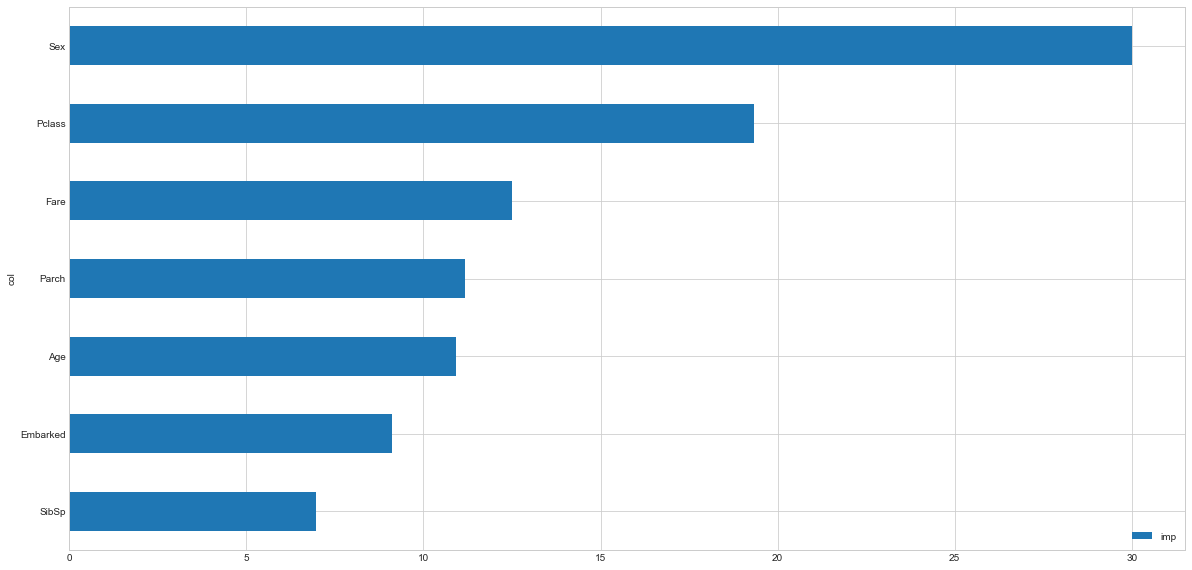

In [98]:
# Plot the feature importance scores
feature_importance(catboost_model, X_train)

# Precision and Recall
Precision and recall are two metrics which are used for cases where you have have an imbalanced classification problem.

For example, you may have 100,000 people and only 1 of them gets a certain disease. If your model predicts that all people don't have the disease, it only misses 1 in 100,000 so its accuracy is 99.999%. But this isn't really helpful.

This is where precision an recall come in.

**Recall** = a metric which measures a models ability to find all the relevant cases in a dataset.

Recall would be the models ability to find the 1 person in 100,000 who has the disease.

**Precision** = a metric which measures a models ability to correctly identify only relevant instances.

In our example, Precision would be if the model found the 1 person who had the disease, did they actually have the disease.

Combining the precision and recall, gives an **F1 score**.

These metrics will all fall between 0 and 1, with a higher value being better.

Although, they don't necessarily need to come into play for our Titantic problem, they're worth remembering for your future work.

In [99]:
metrics = ['Precision', 'Recall', 'F1', 'AUC']

eval_metrics = catboost_model.eval_metrics(train_pool,
                                           metrics=metrics,
                                           plot=True)

for metric in metrics:
    print(str(metric)+": {}".format(np.mean(eval_metrics[metric])))

Precision: 0.8922002090101286
Recall: 0.7360029411764707
F1: 0.8058768163122926
AUC: 0.9150960275366976


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Recall is low, this means there's a higher amount of false negatives (predicting Did not survive when it was actually Survived).

Precision is higher therefore there's less false positives (predicting Survived, when it was actually Did not survive).

Challenge: What are some ways to visualise precision and recall? Hint: You may want to look into what a confusion matrix is, you can find much more information in this blog post: [ Beyond Accuracy: Precision and Recall](https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c)

# Submission

In [104]:
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,2,1,28,1,0,18,2
1,0,0,52,1,0,207,0
2,2,0,34,0,0,41,2
3,0,0,48,1,0,189,2
4,2,1,48,0,0,43,2


In [101]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [107]:
# wanted_test_columns = df_con.drop('Survived', axis= 1).columns
wanted_test_columns = X_train.columns
wanted_test_columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'], dtype='object')

In [109]:
predictions = catboost_model.predict(test[wanted_test_columns].apply(LabelEncoder().fit_transform))

In [110]:
predictions[:20]

array([0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0.,
       0., 1., 1.])

In [111]:
submission = pd.DataFrame()
submission['PassengerId'] = test['PassengerId']
submission['Survived'] = predictions
submission.head()

,PassengerId,Survived
0,892,0.0
1,893,0.0
2,894,0.0
3,895,0.0
4,896,0.0


In [112]:
gender_submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [113]:
submission['Survived'] = submission['Survived'].astype(int)
print('Converted Survived Column to integers')

Converted Survived Column to integers


In [114]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [115]:
if(len(submission) == len(test)):
    print("Submission dataframe is the same length as test ({} rows).".format(len(submission)))
else:
    print("Dataframes mismatched, won't be able to submit to Kaggle.")

Submission dataframe is the same length as test (418 rows).


In [116]:
submission.to_csv('catboost_submission.csv', index=False)
print('Submission CSV is ready!')

Submission CSV is ready!


In [117]:
submission_check = pd.read_csv('catboost_submission.csv')
submission_check.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
